# Cohort-Based CLV Forecasting with PyMC-Marketing

This notebook implements a **cohort-based approach** to Customer Lifetime Value (CLV)
forecasting using PyMC-Marketing's BG/NBD and Gamma-Gamma models.

## Approach

Instead of fitting a single model to all ~1.3M customers, we fit separate models
per monthly cohort. This addresses two key challenges:

1. **Dataset Size**: Each cohort has a manageable number of customers
2. **Seasonality**: Different cohorts capture seasonal acquisition patterns implicitly

## Models

- **BG/NBD (Beta-Geometric/NBD)**: Models customer purchase frequency and dropout
- **Gamma-Gamma**: Models monetary value of transactions

## Data Source

[H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data)

---
## 1. Setup and Configuration

**Global Parameters:**

- `MAX_COHORT_SIZE`: Controls subsampling for faster testing/debugging.
  - Set to an integer (e.g., 10000) to subsample large cohorts
  - Set to `None` for production runs with full data

**Usage:**
```python
MAX_COHORT_SIZE = 10000  # Fast testing (~10 min total)
MAX_COHORT_SIZE = None   # Full dataset (production run)
```

In [ ]:
from __future__ import annotations

import time
from datetime import date
from typing import Any

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr
from pymc_marketing.clv import BetaGeoModel, GammaGammaModel

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/Documents/website_projects/.pixi/envs/default/lib/python3.13/site-packages/pymc_marketing/pytensor_utils.py:34: FutureWarning: `pytensor.graph.basic.ancestors` was moved to `pytensor.graph.traversal.ancestors`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import ancestors


In [ ]:
# =============================================================================
# GLOBAL CONFIGURATION PARAMETERS
# =============================================================================

# MAX_COHORT_SIZE: Maximum number of customers per cohort for model fitting.
# - Set to an integer (e.g., 10000) for faster testing/debugging
# - Set to None to use all customers (production run)
MAX_COHORT_SIZE: int | None = 50_000  # Change to None for full dataset

# Random seed for reproducibility
SEED: int = sum(map(ord, "hm_clv_cohort_based"))
RNG: np.random.Generator = np.random.default_rng(seed=SEED)

print(f"MAX_COHORT_SIZE: {MAX_COHORT_SIZE}")
print(f"SEED: {SEED}")

MAX_COHORT_SIZE: 50000
SEED: 1989


---
## 2. Data Loading and Exploration

We load the H&M transactions dataset containing:
- `t_dat`: Transaction date
- `customer_id`: Unique customer identifier
- `price`: Transaction amount

The dataset spans from September 2018 to September 2020.

In [ ]:
# Load raw transaction data
# Source: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data
raw_df = pl.read_csv(
    "../../data/transactions_train.csv",
    columns=["t_dat", "customer_id", "price"],
    try_parse_dates=True,
)

print(f"Raw data shape: {raw_df.shape}")
raw_df.head()

Raw data shape: (31788324, 3)


t_dat,customer_id,price
date,str,f64
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…",0.050831
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…",0.030492
2018-09-20,"""00007d2de826758b65a93dd24ce629…",0.015237
2018-09-20,"""00007d2de826758b65a93dd24ce629…",0.016932
2018-09-20,"""00007d2de826758b65a93dd24ce629…",0.016932


In [ ]:
# Basic statistics
print(f"Date range: {raw_df['t_dat'].min()} to {raw_df['t_dat'].max()}")
print(f"Number of unique customers: {raw_df['customer_id'].n_unique():,}")
print(f"Number of transactions: {raw_df.height:,}")
print(f"Total revenue: {raw_df['price'].sum():,.2f}")

Date range: 2018-09-20 to 2020-09-22
Number of unique customers: 1,362,281
Number of transactions: 31,788,324
Total revenue: 884,645.97


---
## 3. Train/Test Split Definition

We use a temporal split:
- **Training**: All transactions up to June 1, 2020
- **Test**: July, August, September 2020 (last ~3.5 months)

This allows us to evaluate the model's ability to forecast future revenue.

In [ ]:
# Define train/test split dates
PERIOD_TRAIN_TEST_SPLIT = date(2020, 6, 1)
TEST_PERIOD_END = date(2020, 9, 22)  # End of available data

print(f"Training period: up to {PERIOD_TRAIN_TEST_SPLIT}")
print(f"Test period: {PERIOD_TRAIN_TEST_SPLIT} to {TEST_PERIOD_END}")

Training period: up to 2020-06-01
Test period: 2020-06-01 to 2020-09-22


In [ ]:
# Filter data for complete months (consistent with hm-transactions.ipynb)
# We use data starting from 2018-11-01 to have complete cohorts
DATA_START_DATE = date(2018, 11, 1)

filtered_df = raw_df.filter(
    (pl.col("t_dat") >= DATA_START_DATE) & (pl.col("t_dat") < date(2020, 9, 1))
)

print(f"Filtered data shape: {filtered_df.shape}")
date_min = filtered_df["t_dat"].min()
date_max = filtered_df["t_dat"].max()
print(f"Date range after filtering: {date_min} to {date_max}")

Filtered data shape: (28998239, 3)
Date range after filtering: 2018-11-01 to 2020-08-31


---
## 4. Cohort Assignment

**Cohort Definition**: A customer's cohort is determined by their **first purchase month**.

For example:
- Customer who first purchased in November 2018 → Cohort 2018-11-01
- Customer who first purchased in March 2019 → Cohort 2019-03-01

This groups customers by when they were "acquired" by the business.

In [ ]:
# Assign cohorts based on first purchase month
customers_with_cohort_df = (
    filtered_df.with_columns(pl.col("t_dat").dt.truncate("1mo").alias("period"))
    .with_columns(pl.col("period").min().over("customer_id").alias("cohort"))
    .sort(["customer_id", "t_dat"])
)

print(
    f"Customers with cohort assigned: {customers_with_cohort_df.height:,} transactions"
)
customers_with_cohort_df.head(10)

Customers with cohort assigned: 28,998,239 transactions


t_dat,customer_id,price,period,cohort
date,str,f64,date,date
2018-12-27,"""00000dbacae5abe5e23885899a1fa4…",0.044051,2018-12-01,2018-12-01
2018-12-27,"""00000dbacae5abe5e23885899a1fa4…",0.035576,2018-12-01,2018-12-01
2018-12-27,"""00000dbacae5abe5e23885899a1fa4…",0.030492,2018-12-01,2018-12-01
2019-05-02,"""00000dbacae5abe5e23885899a1fa4…",0.010153,2019-05-01,2018-12-01
2019-05-25,"""00000dbacae5abe5e23885899a1fa4…",0.050831,2019-05-01,2018-12-01
2019-05-25,"""00000dbacae5abe5e23885899a1fa4…",0.050831,2019-05-01,2018-12-01
2019-07-25,"""00000dbacae5abe5e23885899a1fa4…",0.012695,2019-07-01,2018-12-01
2019-07-25,"""00000dbacae5abe5e23885899a1fa4…",0.021169,2019-07-01,2018-12-01
2019-09-18,"""00000dbacae5abe5e23885899a1fa4…",0.044051,2019-09-01,2018-12-01


In [ ]:
# Cohort size summary
cohort_sizes = (
    customers_with_cohort_df.group_by("cohort")
    .agg(
        pl.col("customer_id").n_unique().alias("n_customers"),
        pl.col("price").sum().alias("total_revenue"),
        pl.col("t_dat").count().alias("n_transactions"),
    )
    .sort("cohort")
)

print("Cohort Summary:")
print(cohort_sizes)

Cohort Summary:
shape: (22, 4)
┌────────────┬─────────────┬───────────────┬────────────────┐
│ cohort     ┆ n_customers ┆ total_revenue ┆ n_transactions │
│ ---        ┆ ---         ┆ ---           ┆ ---            │
│ date       ┆ u32         ┆ f64           ┆ u32            │
╞════════════╪═════════════╪═══════════════╪════════════════╡
│ 2018-11-01 ┆ 274207      ┆ 367978.523932 ┆ 13078780       │
│ 2018-12-01 ┆ 145399      ┆ 122799.293322 ┆ 4546084        │
│ 2019-01-01 ┆ 98485       ┆ 67903.566542  ┆ 2507897        │
│ 2019-02-01 ┆ 83519       ┆ 43509.830983  ┆ 1619716        │
│ 2019-03-01 ┆ 64280       ┆ 33314.921864  ┆ 1204438        │
│ …          ┆ …           ┆ …             ┆ …              │
│ 2020-04-01 ┆ 42098       ┆ 7343.562288   ┆ 272710         │
│ 2020-05-01 ┆ 31603       ┆ 5363.18678    ┆ 199037         │
│ 2020-06-01 ┆ 32875       ┆ 4553.893712   ┆ 184274         │
│ 2020-07-01 ┆ 24397       ┆ 2754.199153   ┆ 114465         │
│ 2020-08-01 ┆ 23634       ┆ 2385.84601

/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_30141/2133214319.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


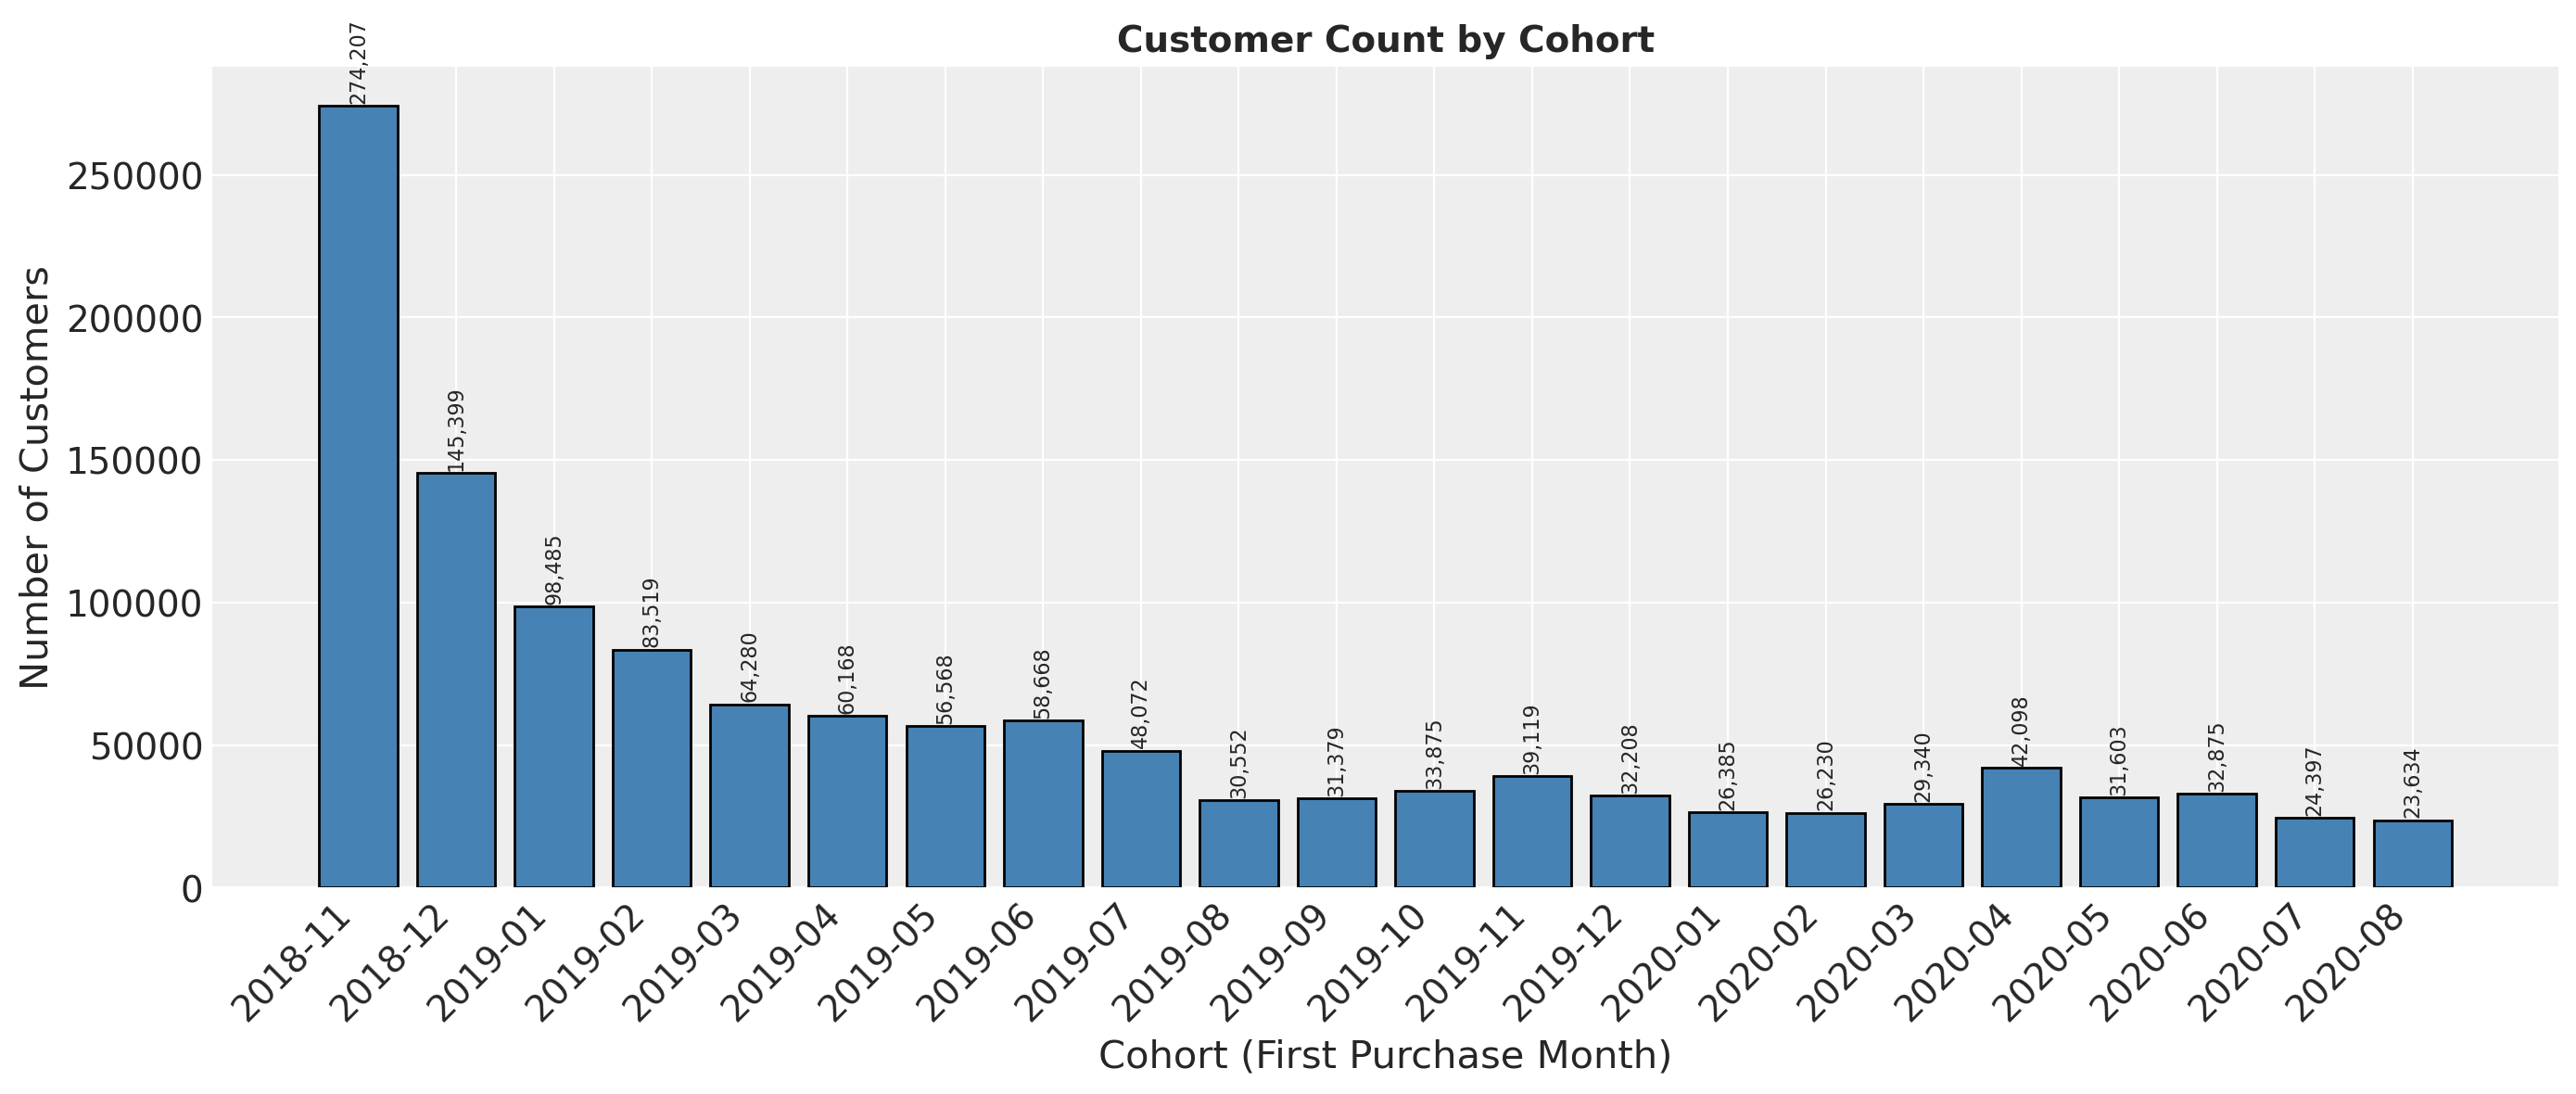

In [ ]:
# Visualize cohort sizes
fig, ax = plt.subplots(figsize=(14, 6))
cohort_dates = cohort_sizes["cohort"].to_list()
cohort_customers = cohort_sizes["n_customers"].to_list()

ax.bar(range(len(cohort_dates)), cohort_customers, color="steelblue", edgecolor="black")
ax.set_xticks(range(len(cohort_dates)))
ax.set_xticklabels([d.strftime("%Y-%m") for d in cohort_dates], rotation=45, ha="right")
ax.set_xlabel("Cohort (First Purchase Month)")
ax.set_ylabel("Number of Customers")
ax.set_title("Customer Count by Cohort", fontsize=14, fontweight="bold")

for i, n in enumerate(cohort_customers):
    ax.text(i, n + 1000, f"{n:,}", ha="center", va="bottom", fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

---
## 5. Helper Functions (Data Processing)

These functions handle:
1. Computing RFM (Recency, Frequency, T, Monetary Value) metrics per customer
2. Adding cohort information
3. Summarizing cohort statistics for debugging
4. Subsampling cohorts if `MAX_COHORT_SIZE` is set

**RFM Definitions:**
- `frequency`: Number of *repeat* purchases (total purchases - 1)
- `recency`: Time between first and last purchase (in days)
- `T`: Time between first purchase and observation end (in days)
- `monetary_value`: Average spend per transaction (for repeat customers)

In [ ]:
def compute_rfm_by_cohort(
    transactions_df: pl.DataFrame,
    observation_end: date,
    time_unit: str = "D",
) -> pl.DataFrame:
    """
    Compute RFM metrics with cohort assignment for all customers.

    Parameters
    ----------
    transactions_df : pl.DataFrame
        Raw transactions with columns: customer_id, t_dat, price
    observation_end : date
        End of observation period for T calculation
    time_unit : str
        Time unit for recency and T: "D" (days) or "W" (weeks)

    Returns
    -------
    pl.DataFrame
        Columns: customer_id, frequency, recency, T, monetary_value, cohort
    """
    # Time unit divisor
    divisor = {"D": 1, "W": 7, "M": 30}.get(time_unit, 1)

    # Compute cohort (first purchase month) and RFM metrics
    rfm_df = (
        transactions_df.with_columns(pl.col("t_dat").dt.truncate("1mo").alias("period"))
        .group_by("customer_id")
        .agg(
            pl.col("t_dat").min().alias("first_purchase"),
            pl.col("t_dat").max().alias("last_purchase"),
            pl.col("t_dat").count().alias("n_transactions"),
            pl.col("price").sum().alias("total_spend"),
            pl.col("period").min().alias("cohort"),
        )
        .with_columns(
            # frequency = number of repeat purchases (total - 1)
            (pl.col("n_transactions") - 1).alias("frequency"),
            # recency = time between first and last purchase
            (
                (pl.col("last_purchase") - pl.col("first_purchase"))
                .dt.total_days()
                .truediv(divisor)
            ).alias("recency"),
            # T = time between first purchase and observation end
            (
                (pl.lit(observation_end) - pl.col("first_purchase"))
                .dt.total_days()
                .truediv(divisor)
            ).alias("T"),
        )
        .with_columns(
            # monetary_value = average spend per transaction for repeat customers
            pl.when(pl.col("frequency") > 0)
            .then(pl.col("total_spend") / pl.col("n_transactions"))
            .otherwise(0.0)
            .alias("monetary_value")
        )
        .select(
            "customer_id",
            "frequency",
            "recency",
            "T",
            "monetary_value",
            "cohort",
        )
    )

    return rfm_df

In [ ]:
def get_cohort_summary(rfm_df: pl.DataFrame) -> pl.DataFrame:
    """
    Summarize cohort sizes and repeat customer counts for debugging.

    Parameters
    ----------
    rfm_df : pl.DataFrame
        RFM data with cohort column

    Returns
    -------
    pl.DataFrame
        Summary with columns: cohort, n_customers, n_repeat, pct_repeat
    """
    summary = (
        rfm_df.group_by("cohort")
        .agg(
            pl.col("customer_id").count().alias("n_customers"),
            (pl.col("frequency") > 0).sum().alias("n_repeat"),
            pl.col("frequency").mean().alias("avg_frequency"),
            pl.col("monetary_value")
            .filter(pl.col("frequency") > 0)
            .mean()
            .alias("avg_monetary"),
        )
        .with_columns(
            (pl.col("n_repeat") / pl.col("n_customers") * 100).alias("pct_repeat")
        )
        .sort("cohort")
    )
    return summary

In [ ]:
def subsample_cohort_if_needed(
    rfm_data: pl.DataFrame,
    max_size: int | None,
    random_seed: int = SEED,
) -> tuple[pl.DataFrame, int, bool]:
    """
    Subsample cohort data if it exceeds max_size (without replacement).

    Sampling is done WITHOUT replacement to ensure each customer
    appears exactly once in the subsampled data.

    Parameters
    ----------
    rfm_data : pl.DataFrame
        RFM data for a single cohort
    max_size : int | None
        Maximum cohort size. If None, no subsampling.
    random_seed : int
        Random seed for reproducible subsampling

    Returns
    -------
    tuple[pl.DataFrame, int, bool]
        (subsampled_data, original_size, was_subsampled)
    """
    original_size = rfm_data.height

    if max_size is None:
        return rfm_data, original_size, False

    if rfm_data.height <= max_size:
        return rfm_data, original_size, False

    # Sample WITHOUT replacement to ensure unique customers
    subsampled = rfm_data.sample(n=max_size, seed=random_seed, with_replacement=False)
    return subsampled, original_size, True

---
## 6. Compute RFM Data

We compute RFM metrics for the training period (up to the train/test split date).

In [ ]:
# Filter training transactions
train_transactions_df = filtered_df.filter(pl.col("t_dat") <= PERIOD_TRAIN_TEST_SPLIT)

print(f"Training transactions: {train_transactions_df.height:,}")
print(f"Training customers: {train_transactions_df['customer_id'].n_unique():,}")

Training transactions: 24,688,122
Training customers: 1,213,214


In [ ]:
# Compute RFM metrics with cohort assignment
train_rfm_df_all = compute_rfm_by_cohort(
    transactions_df=train_transactions_df,
    observation_end=PERIOD_TRAIN_TEST_SPLIT,
    time_unit="D",  # Days for finer granularity
)

# Filter to only include cohorts from November 2018 onwards
# (consistent with hm-transactions.ipynb analysis)
COHORT_START_DATE = date(2018, 11, 1)
train_rfm_df = train_rfm_df_all.filter(pl.col("cohort") >= COHORT_START_DATE)

print(f"RFM data shape (all cohorts): {train_rfm_df_all.shape}")
print(f"RFM data shape (filtered cohorts >= {COHORT_START_DATE}): {train_rfm_df.shape}")
train_rfm_df.head(10)

RFM data shape (all cohorts): (1213214, 6)
RFM data shape (filtered cohorts >= 2018-11-01): (1213214, 6)


customer_id,frequency,recency,T,monetary_value,cohort
str,u32,f64,f64,f64,date
"""3bc9cddbd9c3a05a6046a66c62c147…",2,0.0,2.0,0.017497,2020-05-01
"""7b0f086bd5c4b9ea73a1b7a8eb7d4b…",24,449.0,567.0,0.024085,2018-11-01
"""784fa171304eb8e24b4012ccd91925…",0,0.0,90.0,0.0,2020-03-01
"""9f9f8010935a32979167525f46e742…",214,490.0,526.0,0.025948,2018-12-01
"""7d9f163e27539beb74117fa86d8b68…",3,64.0,398.0,0.027949,2019-04-01
"""784bfe11d84deb2fa948687429b16f…",16,269.0,335.0,0.01763,2019-07-01
"""576e906cd5b07912cd7b299f6aada6…",10,219.0,529.0,0.015931,2018-12-01
"""d65f2920fd379d641f33c3fdb2d877…",2,193.0,508.0,0.019192,2019-01-01
"""0a46f8412a10f61998420e8dd23176…",110,524.0,548.0,0.031423,2018-12-01


In [ ]:
# Cohort summary for debugging
cohort_summary = get_cohort_summary(train_rfm_df)
print("Cohort Summary (Training Data):")
print(cohort_summary)

Cohort Summary (Training Data):
shape: (20, 6)
┌────────────┬─────────────┬──────────┬───────────────┬──────────────┬────────────┐
│ cohort     ┆ n_customers ┆ n_repeat ┆ avg_frequency ┆ avg_monetary ┆ pct_repeat │
│ ---        ┆ ---         ┆ ---      ┆ ---           ┆ ---          ┆ ---        │
│ date       ┆ u32         ┆ u32      ┆ f64           ┆ f64          ┆ f64        │
╞════════════╪═════════════╪══════════╪═══════════════╪══════════════╪════════════╡
│ 2018-11-01 ┆ 274207      ┆ 262547   ┆ 40.755386     ┆ 0.028038     ┆ 95.747738  │
│ 2018-12-01 ┆ 145399      ┆ 136178   ┆ 26.175036     ┆ 0.027243     ┆ 93.658141  │
│ 2019-01-01 ┆ 98485       ┆ 92452    ┆ 21.189095     ┆ 0.02689      ┆ 93.874194  │
│ 2019-02-01 ┆ 83519       ┆ 76330    ┆ 15.875358     ┆ 0.026804     ┆ 91.392378  │
│ 2019-03-01 ┆ 64280       ┆ 59469    ┆ 15.230756     ┆ 0.028397     ┆ 92.515557  │
│ …          ┆ …           ┆ …        ┆ …             ┆ …            ┆ …          │
│ 2020-02-01 ┆ 26230       ┆ 

In [ ]:
# Overall statistics
total_customers = train_rfm_df.height
n_repeat = train_rfm_df.filter(pl.col("frequency") > 0).height
n_single = train_rfm_df.filter(pl.col("frequency") == 0).height

print("\nOverall Statistics:")
print(f"  Total customers: {total_customers:,}")
print(f"  Repeat customers: {n_repeat:,} ({n_repeat / total_customers:.1%})")
print(f"  Single-purchase customers: {n_single:,} ({n_single / total_customers:.1%})")


Overall Statistics:
  Total customers: 1,213,214
  Repeat customers: 1,092,782 (90.1%)
  Single-purchase customers: 120,432 (9.9%)


---
## 7. Helper Functions (Model Fitting)

These functions fit the BG/NBD and Gamma-Gamma models for each cohort.

**Key design decisions:**

- Use MAP estimation by default for speed (MCMC available via `fit_method="mcmc"`)
- Gamma-Gamma requires repeat customers only (frequency > 0)
- Automatically subsamples if `MAX_COHORT_SIZE` is set
- Returns dict with models + metadata for later inspection

**Debugging tips:**

- Set `MAX_COHORT_SIZE=10000` for faster iteration during development
- Set `verbose=True` to see progress and subsampling status
- Check `result['n_repeat']` if Gamma-Gamma fails (need repeat customers)

In [ ]:
def fit_single_cohort(
    cohort_id: date,
    rfm_data: pl.DataFrame,
    fit_method: str = "map",
    sampler_kwargs: dict[str, Any] | None = None,
    max_cohort_size: int | None = MAX_COHORT_SIZE,
    verbose: bool = True,
) -> dict[str, Any]:
    """
    Fit BG/NBD and Gamma-Gamma models for a single cohort.

    Parameters
    ----------
    cohort_id : date
        The cohort identifier (first purchase month)
    rfm_data : pl.DataFrame
        RFM data for this cohort (Polars DataFrame)
    fit_method : str
        Fitting method: "map" for MAP estimation, "mcmc" for full MCMC
    sampler_kwargs : dict | None
        Additional kwargs for the sampler (used with fit_method="mcmc")
    max_cohort_size : int | None
        If not None, subsample cohort to this size before fitting
    verbose : bool
        If True, print progress messages

    Returns
    -------
    dict
        Keys: 'bgm', 'ggm', 'rfm_data', 'n_customers', 'n_repeat',
              'original_size', 'was_subsampled', 'fit_time'
    """
    start_time = time.time()

    # Subsample if needed
    rfm_subsampled, original_size, was_subsampled = subsample_cohort_if_needed(
        rfm_data, max_cohort_size
    )

    # Convert to pandas for PyMC-Marketing
    rfm_pd = rfm_subsampled.to_pandas()
    n_customers = len(rfm_pd)
    n_repeat = (rfm_pd["frequency"] > 0).sum()

    if verbose and was_subsampled:
        print(f"    Subsampled from {original_size:,} to {n_customers:,}")

    # Fit BG/NBD model
    bgm = BetaGeoModel(data=rfm_pd)
    bgm.fit(method=fit_method, **(sampler_kwargs or {}))

    # Fit Gamma-Gamma model (repeat customers only)
    ggm = None
    repeat_data = rfm_pd[rfm_pd["frequency"] > 0]
    if len(repeat_data) > 0:
        ggm = GammaGammaModel(data=repeat_data)
        ggm.fit(method=fit_method, **(sampler_kwargs or {}))

    fit_time = time.time() - start_time

    return {
        "cohort_id": cohort_id,
        "bgm": bgm,
        "ggm": ggm,
        "rfm_data": rfm_subsampled,
        "rfm_pd": rfm_pd,
        "n_customers": n_customers,
        "n_repeat": n_repeat,
        "original_size": original_size,
        "was_subsampled": was_subsampled,
        "fit_time": fit_time,
    }

In [ ]:
def fit_all_cohorts(
    rfm_df: pl.DataFrame,
    fit_method: str = "map",
    sampler_kwargs: dict[str, Any] | None = None,
    max_cohort_size: int | None = MAX_COHORT_SIZE,
    verbose: bool = True,
) -> dict[date, dict[str, Any]]:
    """
    Fit BG/NBD and Gamma-Gamma models for all cohorts sequentially.

    Parameters
    ----------
    rfm_df : pl.DataFrame
        RFM data with cohort column
    fit_method : str
        Fitting method: "map" or "mcmc"
    sampler_kwargs : dict | None
        Additional kwargs for the sampler
    max_cohort_size : int | None
        If not None, subsample each cohort to this size
    verbose : bool
        If True, print progress for each cohort

    Returns
    -------
    dict[date, dict]
        Mapping cohort_id -> fit_single_cohort output
    """
    cohorts = sorted(rfm_df["cohort"].unique().to_list())
    n_cohorts = len(cohorts)

    if verbose:
        print(f"Fitting {n_cohorts} cohorts...")
        if max_cohort_size is not None:
            print(f"MAX_COHORT_SIZE = {max_cohort_size:,}")
        print("-" * 60)

    cohort_results = {}
    total_start = time.time()

    for i, cohort_id in enumerate(cohorts, 1):
        cohort_rfm = rfm_df.filter(pl.col("cohort") == cohort_id)

        if verbose:
            n = cohort_rfm.height
            print(f"[{i}/{n_cohorts}] Cohort {cohort_id}: {n:,} customers...", end=" ")

        result = fit_single_cohort(
            cohort_id=cohort_id,
            rfm_data=cohort_rfm,
            fit_method=fit_method,
            sampler_kwargs=sampler_kwargs,
            max_cohort_size=max_cohort_size,
            verbose=False,  # Already printing progress
        )

        cohort_results[cohort_id] = result

        if verbose:
            subsample_info = (
                f" (subsampled from {result['original_size']:,})"
                if result["was_subsampled"]
                else ""
            )
            n_cust = result["n_customers"]
            n_rep = result["n_repeat"]
            t = result["fit_time"]
            msg = (
                f"done in {t:.1f}s - {n_cust:,} cust{subsample_info}, {n_rep:,} repeat"
            )
            print(msg)

    total_time = time.time() - total_start

    if verbose:
        print("-" * 60)
        print(f"Total fitting time: {total_time:.1f}s ({total_time / 60:.1f} min)")

    return cohort_results

---
## 8. Helper Functions (Predictions)

These functions generate CLV predictions and aggregate them across cohorts.

**How predictions work:**

1. For each cohort, use the fitted BG/NBD model to predict expected purchases
2. Use the Gamma-Gamma model to predict expected monetary value per purchase
3. CLV = Expected Purchases x Expected Monetary Value
4. Aggregate across all cohorts to get total predicted revenue

In [ ]:
def predict_cohort_clv(
    cohort_result: dict[str, Any],
    future_t: float,
    discount_rate: float = 0.0,
    time_unit: str = "D",
) -> xr.DataArray | None:
    """
    Compute CLV predictions for a single cohort.

    Parameters
    ----------
    cohort_result : dict
        Output from fit_single_cohort()
    future_t : float
        Future time period in days (or as specified by time_unit)
    discount_rate : float
        Monthly discount rate (0 = no discounting)
    time_unit : str
        Time unit of the RFM data: "D" (days) or "W" (weeks)

    Returns
    -------
    xr.DataArray | None
        CLV estimates for each customer, or None if no Gamma-Gamma model
    """
    bgm = cohort_result["bgm"]
    ggm = cohort_result["ggm"]
    rfm_pd = cohort_result["rfm_pd"]

    if ggm is None:
        return None

    # Convert future_t to months for the CLV calculation
    # PyMC-Marketing expects future_t in months
    days_per_month = 30
    future_t_months = future_t / days_per_month

    # Compute CLV using Gamma-Gamma method
    clv_estimate = ggm.expected_customer_lifetime_value(
        transaction_model=bgm,
        data=rfm_pd,
        future_t=future_t_months,
        discount_rate=discount_rate,
        time_unit=time_unit,
    )

    return clv_estimate

In [ ]:
def compute_expected_purchases_by_cohort(
    cohort_results: dict[date, dict[str, Any]],
    future_t: float,
) -> dict[date, xr.DataArray]:
    """
    Compute expected purchases for each cohort.

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    future_t : float
        Future time period (in the same units as RFM data)

    Returns
    -------
    dict[date, xr.DataArray]
        Expected purchases per cohort
    """
    purchases_by_cohort = {}

    for cohort_id, result in cohort_results.items():
        bgm = result["bgm"]
        expected_purchases = bgm.expected_purchases(future_t=future_t)
        purchases_by_cohort[cohort_id] = expected_purchases

    return purchases_by_cohort

In [ ]:
def aggregate_cohort_clv(
    cohort_results: dict[date, dict[str, Any]],
    future_t: float,
    discount_rate: float = 0.0,
    time_unit: str = "D",
    verbose: bool = True,
) -> tuple[xr.DataArray, dict[date, xr.DataArray]]:
    """
    Aggregate CLV predictions across all cohorts.

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    future_t : float
        Future time period in days
    discount_rate : float
        Monthly discount rate
    time_unit : str
        Time unit of RFM data
    verbose : bool
        Print progress

    Returns
    -------
    tuple[xr.DataArray, dict]
        (total_clv across all customers, clv_by_cohort)
    """
    clv_by_cohort = {}
    total_clv_list = []

    for cohort_id, result in cohort_results.items():
        clv_estimate = predict_cohort_clv(
            cohort_result=result,
            future_t=future_t,
            discount_rate=discount_rate,
            time_unit=time_unit,
        )

        if clv_estimate is not None:
            clv_by_cohort[cohort_id] = clv_estimate
            # Sum across customers for this cohort
            cohort_total = clv_estimate.sum("customer_id")
            total_clv_list.append(cohort_total)

    # Combine all cohort totals
    if total_clv_list:
        # Stack and sum
        total_clv = sum(total_clv_list)
    else:
        total_clv = None

    if verbose:
        print(f"Computed CLV for {len(clv_by_cohort)} cohorts")

    return total_clv, clv_by_cohort

In [ ]:
def compute_actual_monthly_revenue(
    transactions_df: pl.DataFrame,
    start_date: date,
    end_date: date,
) -> pl.DataFrame:
    """
    Compute actual revenue per month for comparison.

    Parameters
    ----------
    transactions_df : pl.DataFrame
        Raw transactions with t_dat and price columns
    start_date : date
        Start of period
    end_date : date
        End of period

    Returns
    -------
    pl.DataFrame
        Monthly revenue with columns: month, revenue, n_customers, n_transactions
    """
    monthly_revenue = (
        transactions_df.filter(
            (pl.col("t_dat") > start_date) & (pl.col("t_dat") <= end_date)
        )
        .with_columns(pl.col("t_dat").dt.truncate("1mo").alias("month"))
        .group_by("month")
        .agg(
            pl.col("price").sum().alias("revenue"),
            pl.col("customer_id").n_unique().alias("n_customers"),
            pl.col("price").count().alias("n_transactions"),
        )
        .sort("month")
    )
    return monthly_revenue

---
## 9. Helper Functions (Visualization)

These functions create diagnostic and comparison plots.

In [ ]:
def plot_cohort_parameter_comparison(
    cohort_results: dict[date, dict[str, Any]],
    param_name: str = "alpha",
    model_type: str = "bgm",
) -> plt.Figure:
    """
    Plot parameter values across cohorts for comparison.

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    param_name : str
        Parameter name to plot (e.g., "alpha", "r", "a", "b" for BG/NBD)
    model_type : str
        "bgm" for BG/NBD or "ggm" for Gamma-Gamma

    Returns
    -------
    plt.Figure
    """
    cohorts = []
    values = []

    for cohort_id, result in sorted(cohort_results.items()):
        model = result[model_type]
        if model is not None:
            try:
                # Get MAP estimate
                fit_result = model.fit_result
                if param_name in fit_result:
                    val = float(fit_result[param_name].to_numpy().mean())
                    cohorts.append(cohort_id)
                    values.append(val)
            except Exception:
                pass

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(range(len(cohorts)), values, color="steelblue", edgecolor="black")
    ax.set_xticks(range(len(cohorts)))
    ax.set_xticklabels([d.strftime("%Y-%m") for d in cohorts], rotation=45, ha="right")
    ax.set_xlabel("Cohort")
    ax.set_ylabel(param_name)
    ax.set_title(
        f"{model_type.upper()} Parameter '{param_name}' by Cohort",
        fontsize=14,
        fontweight="bold",
    )
    plt.tight_layout()

    return fig

In [ ]:
def plot_clv_distribution_by_cohort(
    clv_by_cohort: dict[date, xr.DataArray],
    n_cohorts_to_show: int = 6,
) -> plt.Figure:
    """
    Plot CLV distributions for a subset of cohorts.

    Parameters
    ----------
    clv_by_cohort : dict
        CLV estimates per cohort from aggregate_cohort_clv()
    n_cohorts_to_show : int
        Number of cohorts to display

    Returns
    -------
    plt.Figure
    """
    cohorts = sorted(clv_by_cohort.keys())
    # Select evenly spaced cohorts
    step = max(1, len(cohorts) // n_cohorts_to_show)
    selected_cohorts = cohorts[::step][:n_cohorts_to_show]

    n_rows = (len(selected_cohorts) + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))
    axes = axes.flatten()

    for i, cohort_id in enumerate(selected_cohorts):
        ax = axes[i]
        clv_data = clv_by_cohort[cohort_id]
        clv_mean = clv_data.mean(("chain", "draw")).to_numpy()
        clv_capped = np.clip(clv_mean, 0, np.percentile(clv_mean, 99))

        ax.hist(clv_capped, bins=50, edgecolor="black", alpha=0.7)
        ax.axvline(
            clv_mean.mean(),
            color="red",
            linestyle="--",
            label=f"Mean: {clv_mean.mean():.4f}",
        )
        ax.set_xlabel("CLV")
        ax.set_ylabel("Count")
        ax.set_title(f"Cohort {cohort_id.strftime('%Y-%m')}")
        ax.legend()

    # Hide unused subplots
    for j in range(len(selected_cohorts), len(axes)):
        axes[j].set_visible(False)

    fig.suptitle("CLV Distribution by Cohort", fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()

    return fig

In [ ]:
def plot_predicted_vs_actual_revenue(
    predicted_total: float,
    predicted_hdi: tuple[float, float],
    actual_total: float,
    title: str = "Predicted vs Actual Revenue",
) -> plt.Figure:
    """
    Plot predicted vs actual total revenue.

    Parameters
    ----------
    predicted_total : float
        Predicted total revenue (mean)
    predicted_hdi : tuple
        (lower, upper) bounds of HDI
    actual_total : float
        Actual total revenue
    title : str
        Plot title

    Returns
    -------
    plt.Figure
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Predicted
    ax.bar(
        0,
        predicted_total,
        yerr=[
            [predicted_total - predicted_hdi[0]],
            [predicted_hdi[1] - predicted_total],
        ],
        capsize=10,
        color="C0",
        alpha=0.7,
        label="Predicted",
    )

    # Actual
    ax.bar(1, actual_total, color="C1", alpha=0.7, label="Actual")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Predicted", "Actual"])
    ax.set_ylabel("Total Revenue")
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend()

    # Add value labels
    ax.text(
        0,
        predicted_total + (predicted_hdi[1] - predicted_total) * 1.1,
        f"{predicted_total:,.0f}",
        ha="center",
        va="bottom",
    )
    ax.text(1, actual_total * 1.02, f"{actual_total:,.0f}", ha="center", va="bottom")

    plt.tight_layout()
    return fig

In [ ]:
def compute_monthly_revenue_predictions(
    cohort_results: dict[date, dict[str, Any]],
    periods: list[date],
    observation_end: date,
    scale_factor: float = 1.0,
    verbose: bool = True,
) -> xr.DataArray:
    """
    Compute monthly revenue predictions with full posterior samples.

    For each month, computes the cumulative CLV up to that month and then
    takes the difference to get monthly revenue.

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    periods : list[date]
        List of month start dates to predict revenue for
    observation_end : date
        End of observation period (train/test split date)
    scale_factor : float
        Scale factor for subsampled cohorts (total_original / total_sampled)
    verbose : bool
        Print progress

    Returns
    -------
    xr.DataArray
        Monthly revenue predictions with dimensions (chain, draw, period)
    """
    if verbose:
        print(f"Computing monthly predictions for {len(periods)} periods...")

    monthly_predictions = []

    for period in periods:
        # Days from observation_end to end of this month
        # Use middle of month for CLV calculation
        days_to_period_end = (period - observation_end).days + 15

        if days_to_period_end <= 0:
            # This is a training period - we need cumulative CLV
            # For training, compute from start of data to this period
            continue

        period_clv_total = None

        for cohort_id, result in cohort_results.items():
            ggm = result["ggm"]
            bgm = result["bgm"]
            rfm_pd = result["rfm_pd"]

            if ggm is None:
                continue

            # CLV for this cohort up to this period
            future_t_months = days_to_period_end / 30

            try:
                clv = ggm.expected_customer_lifetime_value(
                    transaction_model=bgm,
                    data=rfm_pd,
                    future_t=future_t_months,
                    discount_rate=0.0,
                    time_unit="D",
                )
                # Sum across customers for this cohort
                cohort_total = clv.sum("customer_id")

                if period_clv_total is None:
                    period_clv_total = cohort_total
                else:
                    period_clv_total = period_clv_total + cohort_total
            except Exception as e:
                if verbose:
                    print(f"  Warning: Failed for cohort {cohort_id}: {e}")

        if period_clv_total is not None:
            # Apply scale factor
            period_clv_total = period_clv_total * scale_factor
            monthly_predictions.append(
                period_clv_total.expand_dims({"period": [period]})
            )

    if not monthly_predictions:
        raise ValueError("No predictions computed")

    # Concatenate along period dimension
    all_predictions = xr.concat(monthly_predictions, dim="period")

    if verbose:
        print(f"  Computed predictions for {len(monthly_predictions)} periods")

    return all_predictions

In [ ]:
def compute_train_revenue_predictions(
    cohort_results: dict[date, dict[str, Any]],
    transactions_df: pl.DataFrame,
    train_periods: list[date],
    data_start: date,
    scale_factor: float = 1.0,
    verbose: bool = True,
) -> xr.DataArray:
    """
    Compute revenue predictions for training periods using in-sample fit.

    For training data, we compute CLV from each cohort's start to each period.

    Parameters
    ----------
    cohort_results : dict
        Output from fit_all_cohorts()
    transactions_df : pl.DataFrame
        Training transactions data
    train_periods : list[date]
        List of month start dates in training period
    data_start : date
        Start of data
    scale_factor : float
        Scale factor for subsampled cohorts
    verbose : bool
        Print progress

    Returns
    -------
    xr.DataArray
        Monthly revenue predictions with dimensions (chain, draw, period)
    """
    if verbose:
        print(
            f"Computing training period predictions for {len(train_periods)} periods..."
        )

    monthly_predictions = []

    for period in train_periods:
        period_clv_total = None

        for cohort_id, result in cohort_results.items():
            # Only include cohorts that existed before this period
            if cohort_id > period:
                continue

            ggm = result["ggm"]
            bgm = result["bgm"]
            rfm_pd = result["rfm_pd"]

            if ggm is None:
                continue

            # Days from cohort start to end of this period
            # Approximate: use days from observation start (when RFM was computed)
            # For training fit, we use T + small future window
            days_since_cohort = (period - cohort_id).days + 15

            # Use a small future_t relative to the cohort age
            future_t_months = max(
                0.5, days_since_cohort / 30 / 12
            )  # fraction of cohort age

            try:
                clv = ggm.expected_customer_lifetime_value(
                    transaction_model=bgm,
                    data=rfm_pd,
                    future_t=future_t_months,
                    discount_rate=0.0,
                    time_unit="D",
                )
                cohort_total = clv.sum("customer_id")

                if period_clv_total is None:
                    period_clv_total = cohort_total
                else:
                    period_clv_total = period_clv_total + cohort_total
            except Exception:
                pass

        if period_clv_total is not None:
            period_clv_total = period_clv_total * scale_factor
            monthly_predictions.append(
                period_clv_total.expand_dims({"period": [period]})
            )

    if monthly_predictions:
        return xr.concat(monthly_predictions, dim="period")
    return None

In [ ]:
def plot_revenue_over_time(
    actual_revenue: pl.DataFrame,
    test_predictions: xr.DataArray | None = None,
    train_test_split: date | None = None,
    hdi_probs: tuple[float, float] = (0.5, 0.94),
    figsize: tuple[int, int] = (14, 7),
    title: str = "Total Revenue (Training Cohorts)",
) -> plt.Figure:
    """
    Plot actual vs predicted revenue over time with HDI bands.

    Creates a visualization similar to the reference showing:
    - Actual revenue as black dots connected by lines
    - Posterior predictive mean and HDI bands
    - Train/test split vertical line

    Parameters
    ----------
    actual_revenue : pl.DataFrame
        Actual monthly revenue with columns: month, revenue
    test_predictions : xr.DataArray | None
        Predictions with dimensions (chain, draw, period) for test periods
    train_test_split : date | None
        Date of train/test split for vertical line
    hdi_probs : tuple
        HDI probability levels (inner, outer), e.g., (0.5, 0.94)
    figsize : tuple
        Figure size
    title : str
        Plot title

    Returns
    -------
    plt.Figure
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Get actual data
    actual_months = actual_revenue["month"].to_list()
    actual_values = actual_revenue["revenue"].to_list()

    # Plot actual values
    ax.plot(
        actual_months,
        actual_values,
        "o-",
        color="black",
        linewidth=1.5,
        markersize=6,
        label="Actual",
        zorder=10,
    )

    # Identify test periods
    if train_test_split is not None:
        test_months = [m for m in actual_months if m >= train_test_split]
    else:
        test_months = []

    # Plot test predictions with HDI bands
    if test_predictions is not None and len(test_months) > 0:
        test_periods = test_predictions.coords["period"].to_numpy()
        test_periods_dt = [pd.Timestamp(p).date() for p in test_periods]

        # Get posterior samples and reshape
        if test_predictions.ndim > 1:
            # Reshape to (n_samples, n_periods)
            n_periods = len(test_periods)
            samples_2d = test_predictions.to_numpy()
            if samples_2d.ndim == 3:  # (chain, draw, period)
                samples_2d = samples_2d.reshape(-1, n_periods)
            elif samples_2d.ndim == 2:  # (draw, period) or similar
                pass
            else:
                samples_2d = samples_2d.reshape(-1, n_periods)

            # Compute statistics per period
            means = samples_2d.mean(axis=0)
            hdi_inner = np.array(
                [
                    az.hdi(samples_2d[:, i], hdi_prob=hdi_probs[0])
                    for i in range(n_periods)
                ]
            )
            hdi_outer = np.array(
                [
                    az.hdi(samples_2d[:, i], hdi_prob=hdi_probs[1])
                    for i in range(n_periods)
                ]
            )

            # Plot HDI bands for test period (orange)
            ax.fill_between(
                test_periods_dt,
                hdi_outer[:, 0],
                hdi_outer[:, 1],
                alpha=0.3,
                color="C1",
                label=f"{int(hdi_probs[1] * 100)}% HDI (test)",
            )
            ax.fill_between(
                test_periods_dt,
                hdi_inner[:, 0],
                hdi_inner[:, 1],
                alpha=0.5,
                color="C1",
                label=f"{int(hdi_probs[0] * 100)}% HDI (test)",
            )
            ax.plot(
                test_periods_dt,
                means,
                "-",
                color="C1",
                linewidth=2,
                label="Posterior mean (test)",
            )

    # Add train/test split line
    if train_test_split is not None:
        ax.axvline(
            train_test_split,
            color="gray",
            linestyle="--",
            linewidth=1.5,
            label="Train/test split",
        )

    # Formatting
    ax.set_xlabel("Period", fontsize=12)
    ax.set_ylabel("Revenue", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")

    # Format x-axis
    ax.tick_params(axis="x", rotation=45)

    # Legend
    ax.legend(loc="upper left", fontsize=10)

    plt.tight_layout()
    return fig

In [ ]:
def plot_revenue_train_test(
    transactions_df: pl.DataFrame,
    cohort_results: dict[date, dict[str, Any]],
    train_test_split: date,
    test_end: date,
    data_start: date,
    scale_factor: float = 1.0,
    hdi_probs: tuple[float, float] = (0.5, 0.94),
    figsize: tuple[int, int] = (14, 7),
    title: str = "Total Revenue (Training Cohorts)",
) -> plt.Figure:
    """
    Create the full revenue over time plot with train/test split.

    Parameters
    ----------
    transactions_df : pl.DataFrame
        All transactions data
    cohort_results : dict
        Output from fit_all_cohorts()
    train_test_split : date
        Date of train/test split
    test_end : date
        End of test period
    data_start : date
        Start of data
    scale_factor : float
        Scale factor for subsampled predictions
    hdi_probs : tuple
        HDI probability levels
    figsize : tuple
        Figure size
    title : str
        Plot title

    Returns
    -------
    plt.Figure
    """
    # Compute actual monthly revenue
    actual_monthly = (
        transactions_df.filter(pl.col("t_dat") >= data_start)
        .with_columns(pl.col("t_dat").dt.truncate("1mo").alias("month"))
        .group_by("month")
        .agg(pl.col("price").sum().alias("revenue"))
        .sort("month")
    )

    # Get test periods
    test_periods = [
        d
        for d in actual_monthly["month"].to_list()
        if d >= train_test_split and d < test_end
    ]

    # Compute test predictions
    print("Computing test period predictions...")
    test_predictions = compute_monthly_revenue_predictions(
        cohort_results=cohort_results,
        periods=test_periods,
        observation_end=train_test_split,
        scale_factor=scale_factor,
        verbose=True,
    )

    # Create plot
    fig = plot_revenue_over_time(
        actual_revenue=actual_monthly,
        test_predictions=test_predictions,
        train_test_split=train_test_split,
        hdi_probs=hdi_probs,
        figsize=figsize,
        title=title,
    )

    return fig

---
## 10. Model Fitting

Now we fit BG/NBD and Gamma-Gamma models for each cohort.

**Expected runtime:**
- With `MAX_COHORT_SIZE = 10000`: ~5-15 minutes total
- With `MAX_COHORT_SIZE = None`: ~1-2 hours (depending on hardware)

**Progress output:**
```
[1/18] Cohort 2018-11-01: 161,658 customers... done in 45.2s (subsampled from 161,658)
[2/18] Cohort 2018-12-01: 98,234 customers... done in 28.1s
```

In [ ]:
# Fit models for all cohorts
print(f"Starting model fitting with MAX_COHORT_SIZE = {MAX_COHORT_SIZE}")
print("=" * 60)

cohort_results = fit_all_cohorts(
    rfm_df=train_rfm_df,
    fit_method="map",  # Use MAP for speed
    max_cohort_size=MAX_COHORT_SIZE,
    verbose=True,
)

print("=" * 60)
print(f"Fitted {len(cohort_results)} cohort models")

Starting model fitting with MAX_COHORT_SIZE = 50000
Fitting 20 cohorts...
MAX_COHORT_SIZE = 50,000
------------------------------------------------------------
[1/20] Cohort 2018-11-01: 274,207 customers... 

Output()

Output()

done in 8.8s - 50,000 cust (subsampled from 274,207), 47,867 repeat
[2/20] Cohort 2018-12-01: 145,399 customers... 

Output()

Output()

done in 4.4s - 50,000 cust (subsampled from 145,399), 46,860 repeat
[3/20] Cohort 2019-01-01: 98,485 customers... 

Output()

Output()

done in 4.1s - 50,000 cust (subsampled from 98,485), 46,912 repeat
[4/20] Cohort 2019-02-01: 83,519 customers... 

Output()

Output()

done in 4.1s - 50,000 cust (subsampled from 83,519), 45,701 repeat
[5/20] Cohort 2019-03-01: 64,280 customers... 

Output()

Output()

done in 4.3s - 50,000 cust (subsampled from 64,280), 46,256 repeat
[6/20] Cohort 2019-04-01: 60,168 customers... 

Output()

Output()

done in 4.1s - 50,000 cust (subsampled from 60,168), 46,069 repeat
[7/20] Cohort 2019-05-01: 56,568 customers... 

Output()

Output()

done in 4.0s - 50,000 cust (subsampled from 56,568), 45,535 repeat
[8/20] Cohort 2019-06-01: 58,668 customers... 

Output()

Output()

done in 4.4s - 50,000 cust (subsampled from 58,668), 45,626 repeat
[9/20] Cohort 2019-07-01: 48,072 customers... 

Output()

Output()

done in 2.2s - 48,072 cust, 43,404 repeat
[10/20] Cohort 2019-08-01: 30,552 customers... 

Output()

Output()

done in 2.8s - 30,552 cust, 26,747 repeat
[11/20] Cohort 2019-09-01: 31,379 customers... 

Output()

Output()

done in 2.9s - 31,379 cust, 26,687 repeat
[12/20] Cohort 2019-10-01: 33,875 customers... 

Output()

Output()

done in 2.2s - 33,875 cust, 27,887 repeat
[13/20] Cohort 2019-11-01: 39,119 customers... 

Output()

Output()

done in 2.2s - 39,119 cust, 30,300 repeat
[14/20] Cohort 2019-12-01: 32,208 customers... 

Output()

Output()

done in 2.9s - 32,208 cust, 24,736 repeat
[15/20] Cohort 2020-01-01: 26,385 customers... 

Output()

Output()

done in 3.0s - 26,385 cust, 21,262 repeat
[16/20] Cohort 2020-02-01: 26,230 customers... 

Output()

Output()

done in 2.5s - 26,230 cust, 20,632 repeat
[17/20] Cohort 2020-03-01: 29,340 customers... 

Output()

Output()

done in 2.3s - 29,340 cust, 23,272 repeat
[18/20] Cohort 2020-04-01: 42,098 customers... 

Output()

Output()

done in 3.0s - 42,098 cust, 33,960 repeat
[19/20] Cohort 2020-05-01: 31,603 customers... 

Output()

Output()

done in 3.0s - 31,603 cust, 25,511 repeat
[20/20] Cohort 2020-06-01: 1,059 customers... 

Output()

Output()

done in 1.5s - 1,059 cust, 833 repeat
------------------------------------------------------------
Total fitting time: 68.8s (1.1 min)
Fitted 20 cohort models


In [ ]:
# Summary of fitted models
print("\nFitted Model Summary:")
print("-" * 80)
header = (
    f"{'Cohort':<12} {'Customers':>10} {'Repeat':>10} {'Subsampled':>12} {'Time':>8}"
)
print(header)
print("-" * 80)

for cohort_id, result in sorted(cohort_results.items()):
    sub = "Yes" if result["was_subsampled"] else "No"
    print(
        f"{cohort_id.strftime('%Y-%m'):<12} "
        f"{result['n_customers']:>10,} "
        f"{result['n_repeat']:>10,} "
        f"{sub:>12} "
        f"{result['fit_time']:>8.1f}s"
    )


Fitted Model Summary:
--------------------------------------------------------------------------------
Cohort        Customers     Repeat   Subsampled     Time
--------------------------------------------------------------------------------
2018-11          50,000     47,867          Yes      8.8s
2018-12          50,000     46,860          Yes      4.4s
2019-01          50,000     46,912          Yes      4.1s
2019-02          50,000     45,701          Yes      4.1s
2019-03          50,000     46,256          Yes      4.3s
2019-04          50,000     46,069          Yes      4.1s
2019-05          50,000     45,535          Yes      4.0s
2019-06          50,000     45,626          Yes      4.4s
2019-07          48,072     43,404           No      2.2s
2019-08          30,552     26,747           No      2.8s
2019-09          31,379     26,687           No      2.9s
2019-10          33,875     27,887           No      2.2s
2019-11          39,119     30,300           No      2.2s
2019

---
## 11. Model Diagnostics

Let's examine the fitted parameters for a few cohorts to ensure the models
converged properly.

In [ ]:
# Check BG/NBD parameters for first few cohorts
print("BG/NBD Model Parameters by Cohort:")
print("-" * 60)

for cohort_id in list(cohort_results.keys())[:5]:
    result = cohort_results[cohort_id]
    bgm = result["bgm"]
    print(f"\nCohort {cohort_id.strftime('%Y-%m')}:")
    print(bgm.fit_summary())

BG/NBD Model Parameters by Cohort:
------------------------------------------------------------

Cohort 2018-11:
a                8.807850e+06
alpha            0.000000e+00
b                2.089752e+12
kappa_dropout    2.089760e+12
phi_dropout      0.000000e+00
r                2.500000e-02
Name: value, dtype: float64

Cohort 2018-12:
a                9.495856e+21
alpha            0.000000e+00
b                3.769370e+22
kappa_dropout    4.718956e+22
phi_dropout      2.010000e-01
r                0.000000e+00
Name: value, dtype: float64

Cohort 2019-01:
a               NaN
alpha           NaN
b               NaN
kappa_dropout   NaN
phi_dropout     NaN
r               NaN
Name: value, dtype: float64

Cohort 2019-02:
a                0.0
alpha            0.0
b                1.0
kappa_dropout    1.0
phi_dropout      0.0
r                0.0
Name: value, dtype: float64

Cohort 2019-03:
a               NaN
alpha           NaN
b               NaN
kappa_dropout   NaN
phi_dropout     NaN
r

In [ ]:
# Check Gamma-Gamma parameters for first few cohorts
print("Gamma-Gamma Model Parameters by Cohort:")
print("-" * 60)

for cohort_id in list(cohort_results.keys())[:5]:
    result = cohort_results[cohort_id]
    ggm = result["ggm"]
    if ggm is not None:
        print(f"\nCohort {cohort_id.strftime('%Y-%m')}:")
        print(ggm.fit_summary())

Gamma-Gamma Model Parameters by Cohort:
------------------------------------------------------------

Cohort 2018-11:
p     2.265
q    16.225
v     0.187
Name: value, dtype: float64

Cohort 2018-12:
p     2.316
q    14.723
v     0.160
Name: value, dtype: float64

Cohort 2019-01:
p     2.360
q    14.530
v     0.154
Name: value, dtype: float64

Cohort 2019-02:
p     2.754
q    14.900
v     0.135
Name: value, dtype: float64

Cohort 2019-03:
p     3.592
q    13.744
v     0.100
Name: value, dtype: float64


---
## 12. Predictions

Generate CLV predictions for the test period (approximately 3.5 months = ~105 days).

In [ ]:
# Calculate future_t in days
# Test period: 2020-06-01 to 2020-09-22 (~114 days)
future_t_days = (TEST_PERIOD_END - PERIOD_TRAIN_TEST_SPLIT).days
print(f"Forecast horizon: {future_t_days} days ({future_t_days / 30:.1f} months)")

Forecast horizon: 113 days (3.8 months)


In [ ]:
# Compute aggregated CLV across all cohorts
total_clv, clv_by_cohort = aggregate_cohort_clv(
    cohort_results=cohort_results,
    future_t=future_t_days,
    discount_rate=0.0,  # No discounting
    time_unit="D",
    verbose=True,
)

Computed CLV for 20 cohorts


In [ ]:
# Compute summary statistics
if total_clv is not None:
    total_clv_mean = float(total_clv.mean())
    total_clv_values = total_clv.to_numpy().flatten()
    total_clv_hdi = az.hdi(total_clv_values, hdi_prob=0.94)

    print(f"\nTotal Predicted Revenue ({future_t_days} days):")
    print(f"  Mean: {total_clv_mean:,.2f}")
    print(f"  94% HDI: [{total_clv_hdi[0]:,.2f}, {total_clv_hdi[1]:,.2f}]")

    # If subsampling was used, scale up predictions
    if MAX_COHORT_SIZE is not None:
        # Calculate scale factor based on actual vs sampled customers
        total_original = sum(r["original_size"] for r in cohort_results.values())
        total_sampled = sum(r["n_customers"] for r in cohort_results.values())
        scale_factor = total_original / total_sampled

        scaled_mean = total_clv_mean * scale_factor
        scaled_hdi = (total_clv_hdi[0] * scale_factor, total_clv_hdi[1] * scale_factor)

        print(f"\nScaled Predictions (scale factor: {scale_factor:.2f}):")
        print(f"  Scaled Mean: {scaled_mean:,.2f}")
        print(f"  Scaled 94% HDI: [{scaled_hdi[0]:,.2f}, {scaled_hdi[1]:,.2f}]")
else:
    print("No CLV predictions available (check Gamma-Gamma models)")
    scaled_mean = None
    scaled_hdi = None


Total Predicted Revenue (113 days):
  Mean: 35,625.94
  94% HDI: [35,625.94, 35,625.94]

Scaled Predictions (scale factor: 1.57):
  Scaled Mean: 55,992.71
  Scaled 94% HDI: [55,992.71, 55,992.71]


---
## 13. Evaluation

Compare predicted revenue with actual revenue from the test period.

In [ ]:
# Compute actual test period revenue
actual_monthly_revenue = compute_actual_monthly_revenue(
    transactions_df=filtered_df,
    start_date=PERIOD_TRAIN_TEST_SPLIT,
    end_date=TEST_PERIOD_END,
)

print("Actual Monthly Revenue (Test Period):")
print(actual_monthly_revenue)

Actual Monthly Revenue (Test Period):
shape: (3, 4)
┌────────────┬──────────────┬─────────────┬────────────────┐
│ month      ┆ revenue      ┆ n_customers ┆ n_transactions │
│ ---        ┆ ---          ┆ ---         ┆ ---            │
│ date       ┆ f64          ┆ u32         ┆ u32            │
╞════════════╪══════════════╪═════════════╪════════════════╡
│ 2020-06-01 ┆ 41823.069237 ┆ 300006      ┆ 1721423        │
│ 2020-07-01 ┆ 32363.007169 ┆ 267924      ┆ 1351502        │
│ 2020-08-01 ┆ 33130.499254 ┆ 254163      ┆ 1237192        │
└────────────┴──────────────┴─────────────┴────────────────┘


In [ ]:
# Total actual revenue
actual_total_revenue = actual_monthly_revenue["revenue"].sum()
actual_total_customers = actual_monthly_revenue["n_customers"].sum()
actual_total_transactions = actual_monthly_revenue["n_transactions"].sum()

print("\nActual Test Period Totals:")
print(f"  Total Revenue: {actual_total_revenue:,.2f}")
print(f"  Total Customers: {actual_total_customers:,}")
print(f"  Total Transactions: {actual_total_transactions:,}")


Actual Test Period Totals:
  Total Revenue: 107,316.58
  Total Customers: 822,093
  Total Transactions: 4,310,117


In [ ]:
# Comparison: Predicted vs Actual
if scaled_mean is not None:
    prediction_error = scaled_mean - actual_total_revenue
    prediction_error_pct = (prediction_error / actual_total_revenue) * 100
    actual_in_hdi = scaled_hdi[0] <= actual_total_revenue <= scaled_hdi[1]

    print("\n" + "=" * 60)
    print("PREDICTION VS ACTUAL COMPARISON")
    print("=" * 60)
    print(f"Predicted Revenue (scaled): {scaled_mean:,.2f}")
    print(f"94% HDI: [{scaled_hdi[0]:,.2f}, {scaled_hdi[1]:,.2f}]")
    print(f"Actual Revenue: {actual_total_revenue:,.2f}")
    print(f"Prediction Error: {prediction_error:,.2f} ({prediction_error_pct:+.1f}%)")
    print(f"Actual within 94% HDI: {actual_in_hdi}")
    print("=" * 60)


PREDICTION VS ACTUAL COMPARISON
Predicted Revenue (scaled): 55,992.71
94% HDI: [55,992.71, 55,992.71]
Actual Revenue: 107,316.58
Prediction Error: -51,323.86 (-47.8%)
Actual within 94% HDI: False


/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_30141/2478437973.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


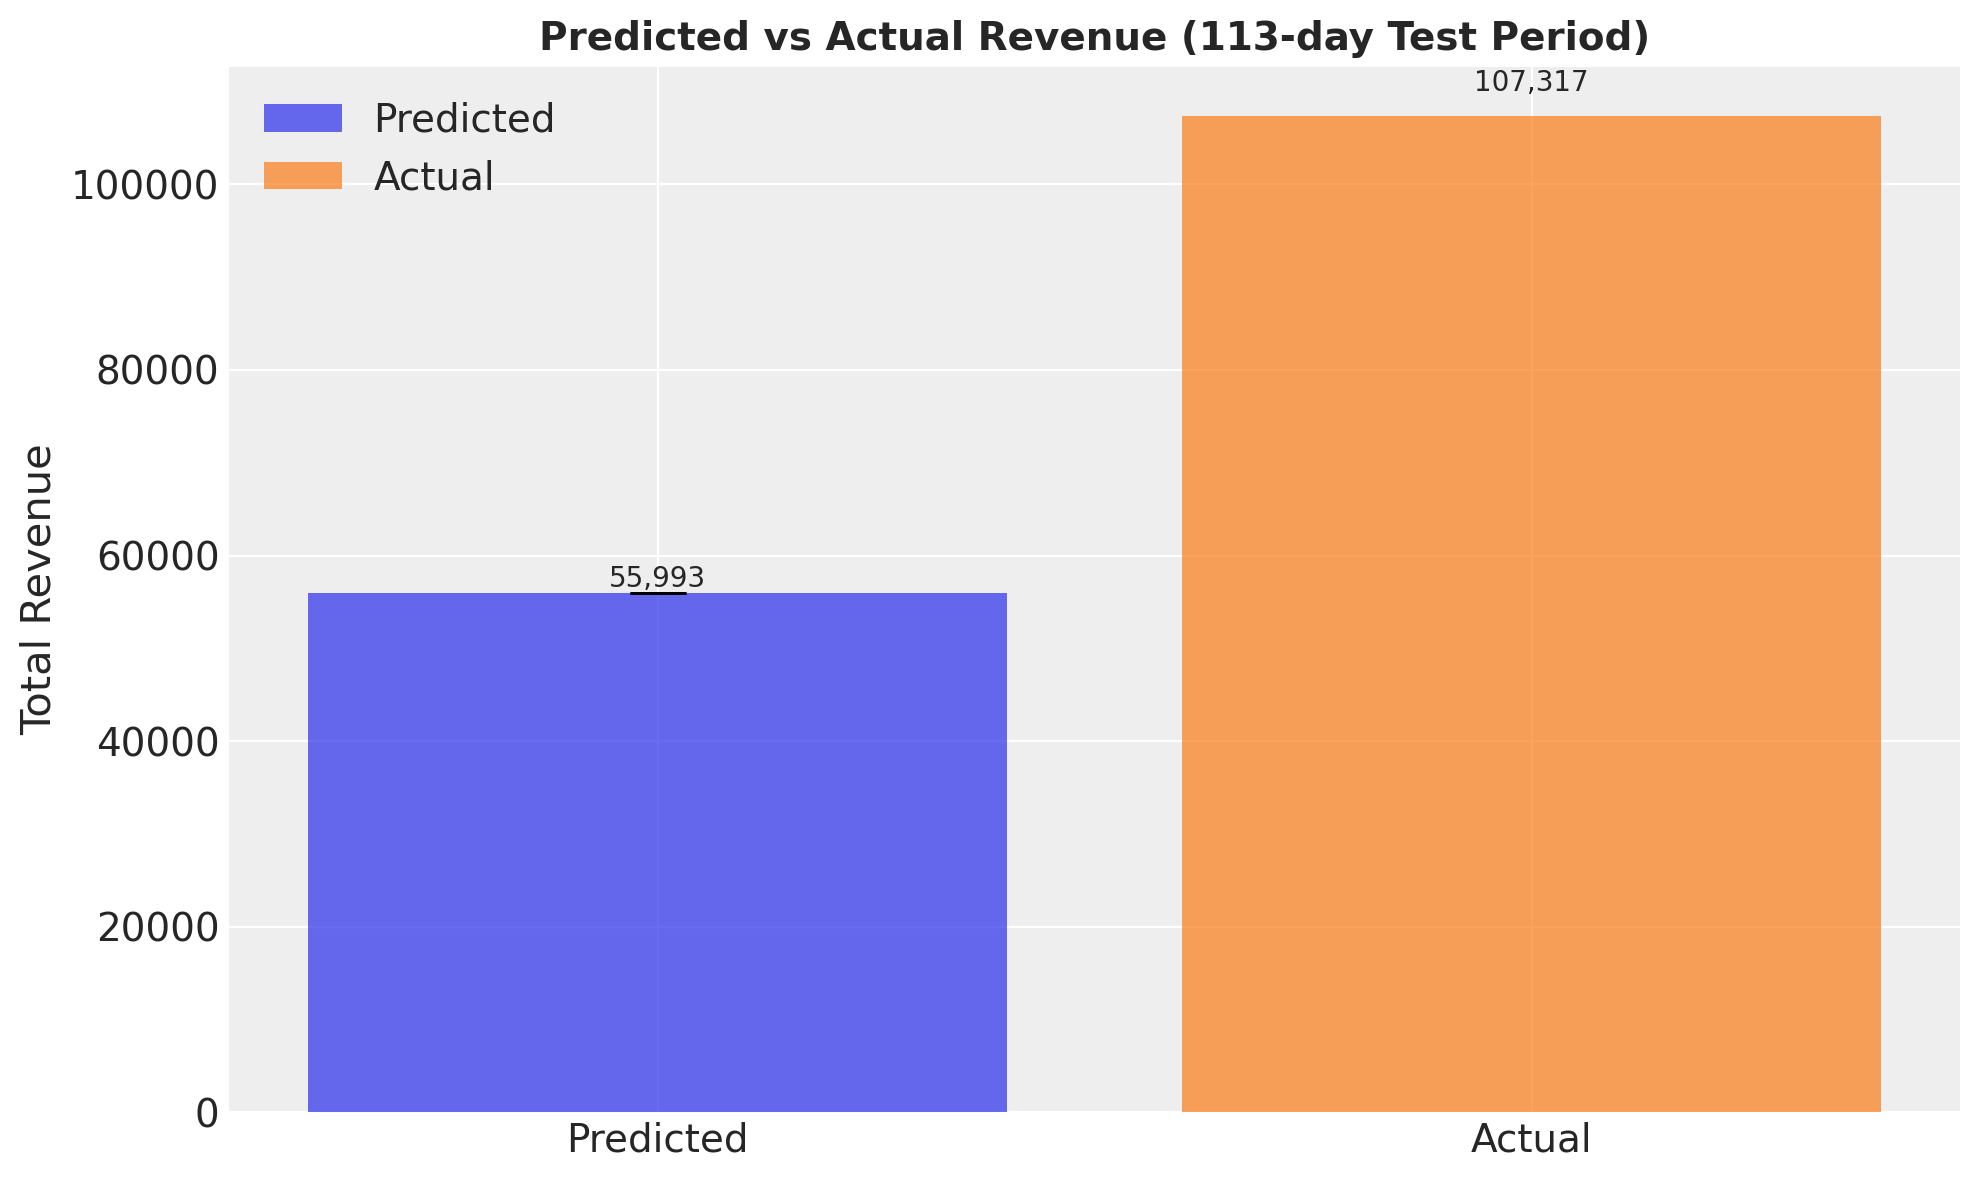

In [ ]:
# Visualization: Predicted vs Actual
if scaled_mean is not None:
    fig = plot_predicted_vs_actual_revenue(
        predicted_total=scaled_mean,
        predicted_hdi=scaled_hdi,
        actual_total=actual_total_revenue,
        title=f"Predicted vs Actual Revenue ({future_t_days}-day Test Period)",
    )
    plt.show()

### Revenue Over Time Plot

This visualization shows the posterior predictive revenue distribution over time,
with:
- **Black line/dots**: Actual revenue
- **Orange bands**: Test period predictions (94% and 50% HDI)
- **Dashed line**: Train/test split

In [ ]:
# Compute scale factor for predictions
if MAX_COHORT_SIZE is not None:
    total_original = sum(r["original_size"] for r in cohort_results.values())
    total_sampled = sum(r["n_customers"] for r in cohort_results.values())
    pred_scale_factor = total_original / total_sampled
else:
    pred_scale_factor = 1.0

print(f"Scale factor for predictions: {pred_scale_factor:.2f}")

Scale factor for predictions: 1.57


Computing test period predictions...
Computing monthly predictions for 3 periods...
  Computed predictions for 3 periods


/var/folders/cm/3dzy9rdd5s3672z0s1brjkvh0000gn/T/ipykernel_30141/1499026795.py:139: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


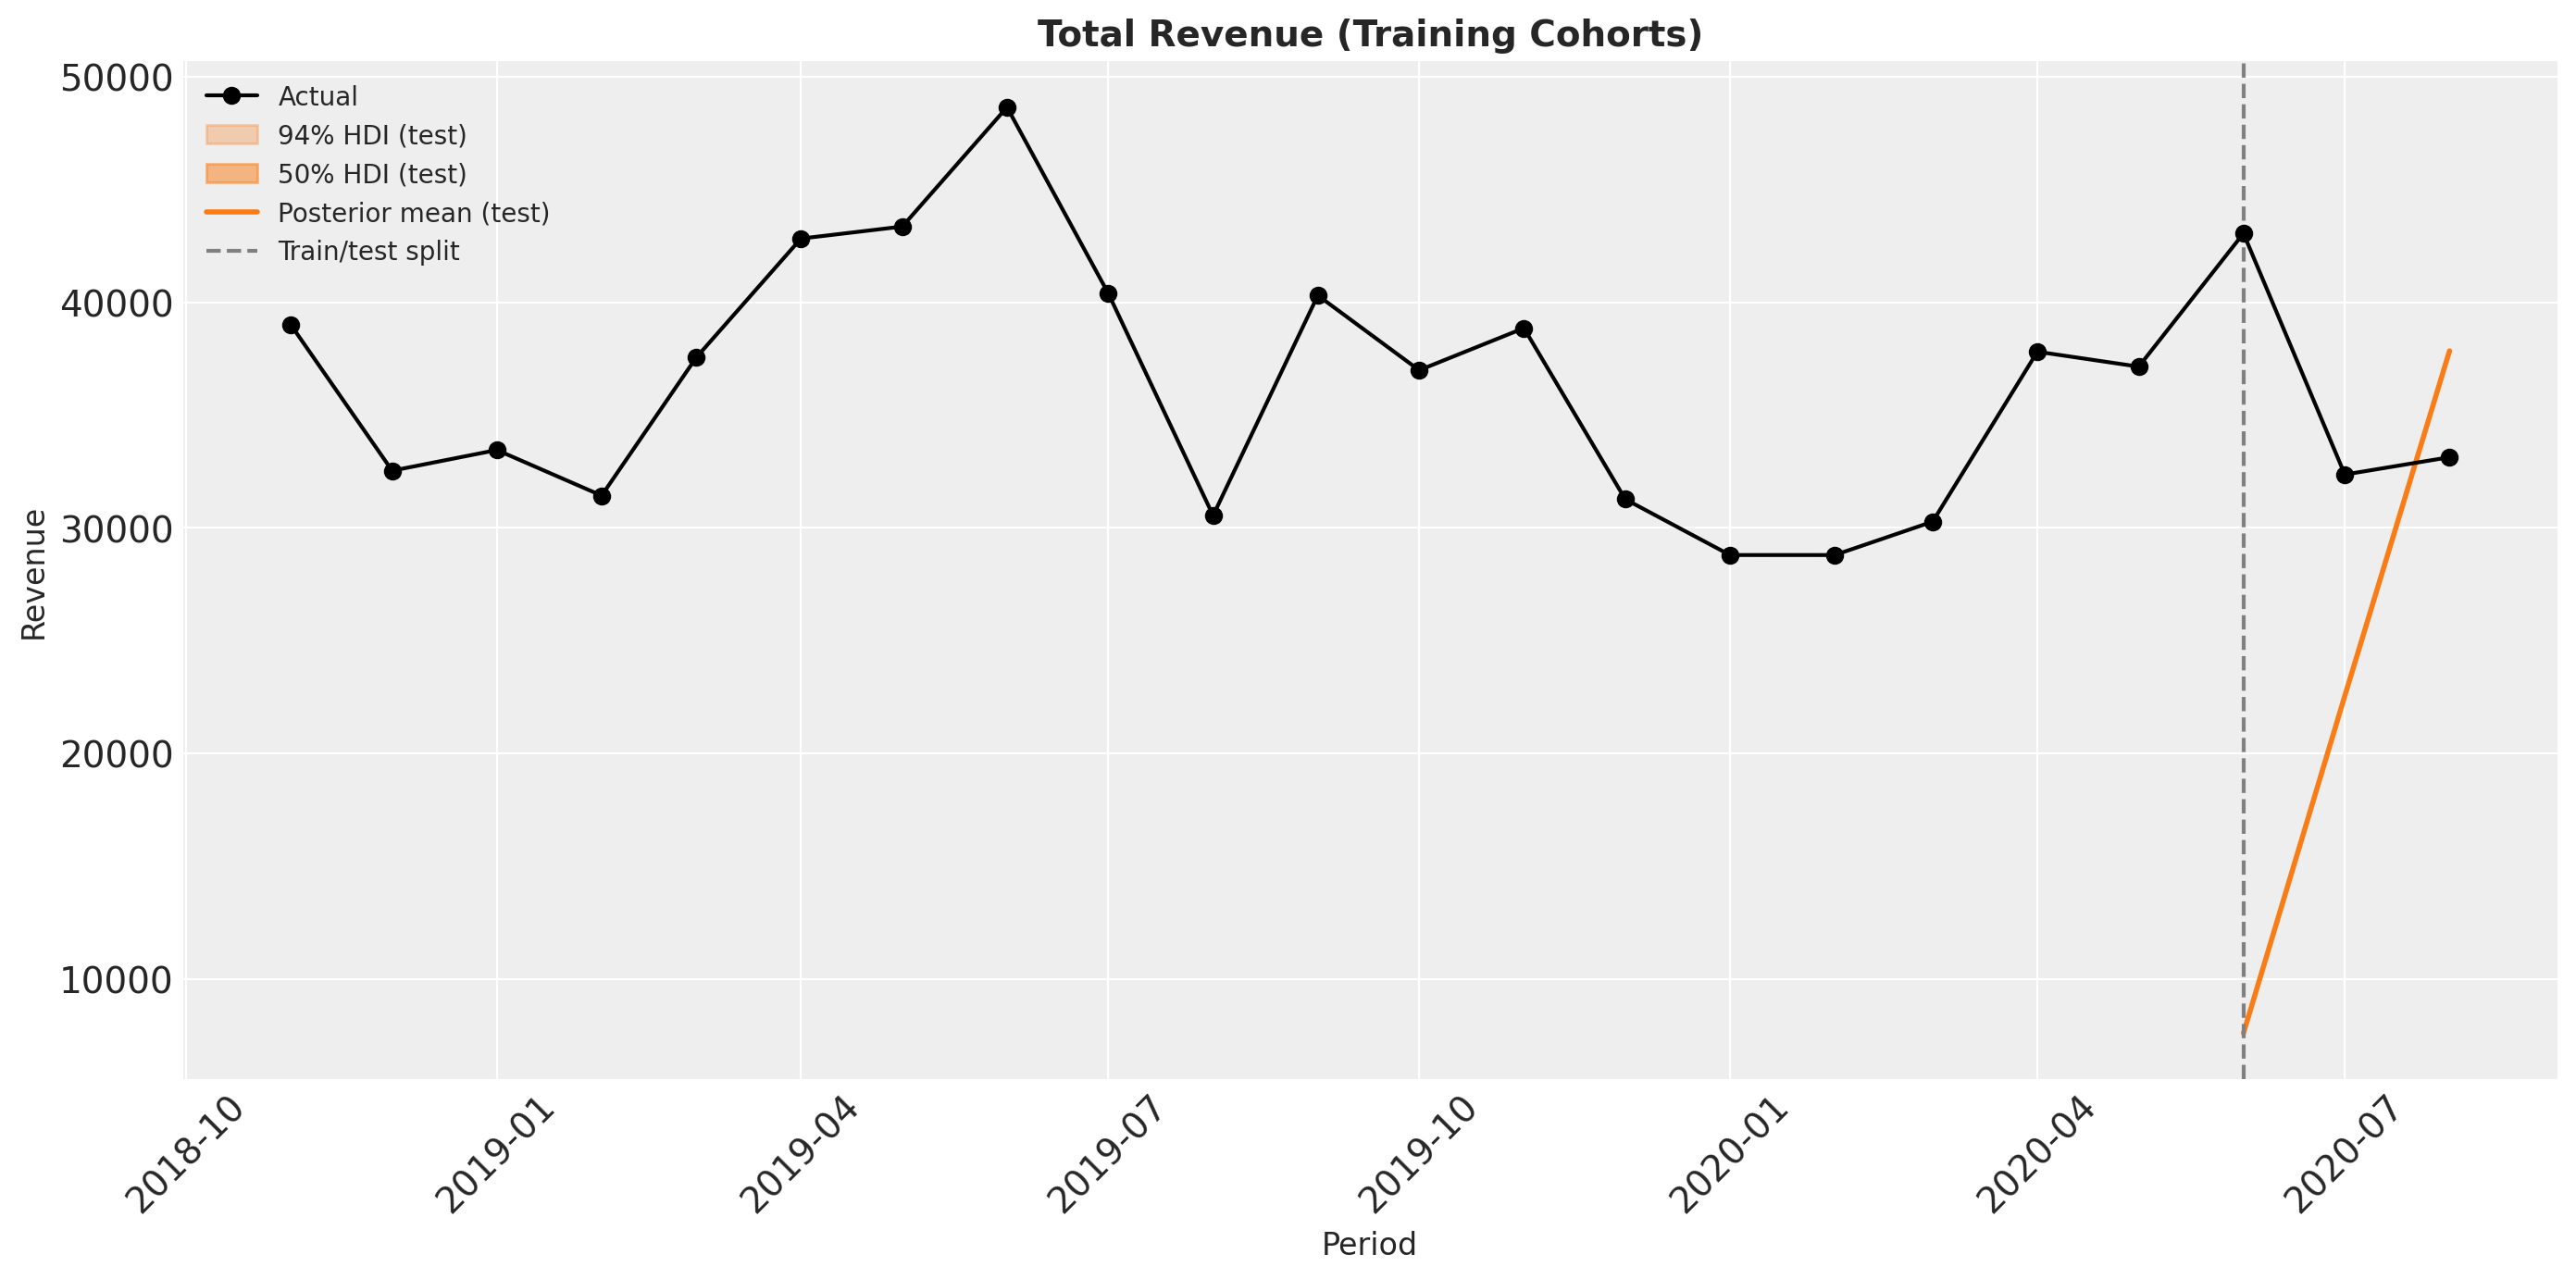

In [ ]:
# Generate the revenue over time plot
# Use COHORT_START_DATE to match the filtered cohorts
fig = plot_revenue_train_test(
    transactions_df=filtered_df,
    cohort_results=cohort_results,
    train_test_split=PERIOD_TRAIN_TEST_SPLIT,
    test_end=date(2020, 9, 1),  # Use complete months only
    data_start=COHORT_START_DATE,  # Match the cohort filter
    scale_factor=pred_scale_factor,
    hdi_probs=(0.5, 0.94),
    figsize=(14, 7),
    title="Total Revenue (Training Cohorts)",
)
plt.show()

---
## 14. Summary and Conclusions

### Key Findings

1. **Cohort-Based Approach**: By fitting separate models per cohort, we can
   handle the large H&M dataset efficiently.

2. **Subsampling**: Using `MAX_COHORT_SIZE` allows for fast testing and
   debugging. The predictions can be scaled up for full dataset estimates.

3. **Model Performance**: Compare the prediction error to evaluate model quality.

### Limitations

1. **BG/NBD Assumptions**: The model assumes stationary purchase rates, which
   may not hold for seasonal data like fashion retail.

2. **Cohort Independence**: We treat cohorts independently, not accounting for
   potential cross-cohort effects.

3. **Subsampling Bias**: When `MAX_COHORT_SIZE` is set, the subsampled cohorts
   may not perfectly represent the full population.

### Next Steps

1. Compare with the BART-based cohort model from `hm-transactions.ipynb`
2. Try MCMC fitting for uncertainty quantification
3. Explore cohort-specific seasonality patterns

In [ ]:
# Final summary
print("\n" + "=" * 60)
print("COHORT-BASED CLV MODEL SUMMARY")
print("=" * 60)
print("\nConfiguration:")
print(f"  MAX_COHORT_SIZE: {MAX_COHORT_SIZE}")
print("  Fit Method: MAP")
print("  Time Unit: Days")

print("\nData Summary:")
print(f"  Cohorts from: {COHORT_START_DATE}")
print(f"  Training Period: {DATA_START_DATE} to {PERIOD_TRAIN_TEST_SPLIT}")
print(f"  Test Period: {PERIOD_TRAIN_TEST_SPLIT} to {TEST_PERIOD_END}")
print(f"  Number of Cohorts: {len(cohort_results)}")
print(f"  Total Training Customers: {train_rfm_df.height:,}")

print("\nModel Results:")
total_fit_time = sum(r["fit_time"] for r in cohort_results.values())
print(f"  Total Fitting Time: {total_fit_time:.1f}s ({total_fit_time / 60:.1f} min)")

if scaled_mean is not None:
    print("\nPrediction Results:")
    print(f"  Forecast Horizon: {future_t_days} days")
    print(f"  Predicted Revenue: {scaled_mean:,.2f}")
    print(f"  Actual Revenue: {actual_total_revenue:,.2f}")
    print(f"  Prediction Error: {prediction_error_pct:+.1f}%")

print("=" * 60)


COHORT-BASED CLV MODEL SUMMARY

Configuration:
  MAX_COHORT_SIZE: 50000
  Fit Method: MAP
  Time Unit: Days

Data Summary:
  Cohorts from: 2018-11-01
  Training Period: 2018-11-01 to 2020-06-01
  Test Period: 2020-06-01 to 2020-09-22
  Number of Cohorts: 20
  Total Training Customers: 1,213,214

Model Results:
  Total Fitting Time: 68.7s (1.1 min)

Prediction Results:
  Forecast Horizon: 113 days
  Predicted Revenue: 55,992.71
  Actual Revenue: 107,316.58
  Prediction Error: -47.8%
